## Homework 01. Simple text processing.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display
from typing import Mapping, Any, TypeVar, Sequence
import os

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [2]:
# In colab uncomment this cell
# ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

In [2]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

In [3]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \r\n\r\nI am sorry, but you se..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\r\n\r\nCheck out the Wikipedia:...


In [4]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

def preprocess(text): 
    return ' '.join(tokenizer.tokenize(text.lower()))

# vectorized version of the preprocess, could be applyed to numpy array
preprocess_vec = np.vectorize(preprocess)

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [6]:
# task: preprocess each comment in train and test

texts_train = preprocess_vec(texts_train)
texts_test = preprocess_vec(texts_test)

In [7]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [9]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
from collections import Counter


k = min(10000, len(set(' '.join(texts_train).split())))

token_counter = Counter()
def count_tokens(x, counter):
    counter.update(tokenizer.tokenize(x))
    return x
count_tokens_vec = np.vectorize(count_tokens)
count_tokens_vec(texts_train, token_counter)

bow_vocabulary = [word for word, _ in token_counter.most_common(k)]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12.176', '2k15', '[', 'admitting', 'also', 'arborsculpture', 'authority', 'bending', 'botticelli', 'cam', 'chemical', 'comapre', "consulate's", 'credibility', 'decide', 'diareah', 'dogs', 'editwarring', 'espouse', 'facts', 'finn', 'fringe', 'glow', 'handle', 'himself', 'ideas', 'info', "israel's", 'killings', 'let', 'losers', 'mckay', 'moderately', 'nationality', 'notice', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [90]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
from collections import Counter

T = TypeVar('T')


def count_tokens(x: T, 
                 counter: Counter) -> T:
    counter.update(tokenizer.tokenize(x))
    return x
count_tokens_vec = np.vectorize(count_tokens)


def get_bow_tokens(texts: np.array,
                   k: int) -> Sequence[str]:
    token_counter = Counter()
    count_tokens_vec(texts, token_counter)

    return token_counter.most_common(k)


def get_bow_vocabulary_dict(texts: np.array, 
                            k: int) -> Mapping[str, int]:
    return {v: i for i, (v, _) in enumerate(get_bow_tokens(texts, k))}


def text_to_bow(text: str, 
                bow_dict: Mapping[str, int]) -> np.array:
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    tmp_counter = Counter(tokenizer.tokenize(text))
    tmp = np.zeros(len(bow_dict), dtype='float32') 
    for k,v in tmp_counter.items():
        k = bow_dict.get(k, -1)
        if k > -1:
            tmp[k] = v
    return tmp


def texts_to_bow(texts: Sequence[str], 
                 bow_dict: Mapping[str, int]) -> np.array:
    return np.stack(list(map(lambda x: text_to_bow(x, bow_dict), texts)))


k = min(10000, len(set(' '.join(texts_train).split())))

print(f"example features:{os.linesep}"
      f"{os.linesep.join([f'{v} --> {k}' for k, v in sorted(get_bow_tokens(texts_train, k), key=lambda x: -x[1])[::100]])}")

example features:
1511 --> .
51 --> other
22 --> keep
14 --> better
10 --> alone
8 --> grammar
7 --> bash
6 --> answer
5 --> six
4 --> business
4 --> advice
3 --> mentioning
3 --> movies
3 --> trivia
3 --> finding
2 --> watches
2 --> criticisms
2 --> dance
2 --> perceive
2 --> graduation
2 --> key
2 --> reported
2 --> 94.8
2 --> operational
1 --> cleansed
1 --> numnut
1 --> residents
1 --> ill
1 --> consciousness
1 --> antidiskriminator
1 --> viewing
1 --> earth
1 --> abuses
1 --> 06:08
1 --> cleanup.he
1 --> precise
1 --> piercing
1 --> temperarily
1 --> harvey
1 --> raymond
1 --> tiderolls
1 --> enthusiasts
1 --> lyte
1 --> நம்
1 --> flim-flam
1 --> 68.54
1 --> sometime
1 --> nominated
1 --> pasichnyk
1 --> department
1 --> sticker
1 --> thereby
1 --> weavers
1 --> youve
1 --> lift
1 --> directed
1 --> administration
1 --> sniffin


In [58]:
bow_vocabulary_dict

{'.': 0,
 ',': 1,
 'you': 2,
 'the': 3,
 '"': 4,
 'a': 5,
 'to': 6,
 'i': 7,
 'and': 8,
 '!': 9,
 'is': 10,
 'of': 11,
 '=': 12,
 'suck': 13,
 'that': 14,
 'in': 15,
 'hitler': 16,
 'heil': 17,
 'it': 18,
 '(': 19,
 ')': 20,
 'offfuck': 21,
 '?': 22,
 'are': 23,
 'not': 24,
 'this': 25,
 'for': 26,
 'be': 27,
 'your': 28,
 'my': 29,
 'on': 30,
 'as': 31,
 'with': 32,
 'do': 33,
 'have': 34,
 'nigger': 35,
 'j.delanoy': 36,
 'me': 37,
 ':': 38,
 'dick': 39,
 'or': 40,
 'was': 41,
 'if': 42,
 'article': 43,
 'at': 44,
 'know': 45,
 'but': 46,
 'because': 47,
 'what': 48,
 'page': 49,
 'all': 50,
 'an': 51,
 'so': 52,
 'talk': 53,
 '...': 54,
 'by': 55,
 'wikipedia': 56,
 'one': 57,
 'he': 58,
 'they': 59,
 'can': 60,
 'like': 61,
 'no': 62,
 'from': 63,
 'will': 64,
 'has': 65,
 'would': 66,
 "'": 67,
 'been': 68,
 'about': 69,
 'there': 70,
 'fggt': 71,
 'just': 72,
 "don't": 73,
 'any': 74,
 'which': 75,
 'did': 76,
 '2006': 77,
 '-': 78,
 'time': 79,
 'who': 80,
 'when': 81,
 'july': 

In [121]:
bow_vocabulary_dict = get_bow_vocabulary_dict(texts_train, k)

X_train_bow = texts_to_bow(texts_train, bow_vocabulary_dict)
X_test_bow = texts_to_bow(texts_test, bow_vocabulary_dict)

In [63]:
# bow_vocabulary_dict = dict(zip(bow_vocabulary, range(len(bow_vocabulary))))

# def text_to_bow(text, bow_dict):
#     """ convert text string to an array of token counts. Use bow_vocabulary. """
#     tmp_counter = Counter(tokenizer.tokenize(text))
#     tmp = np.zeros(len(bow_dict), dtype='float32') 
#     for k,v in tmp_counter.items():
#         k = bow_dict.get(k, -1)
#         if k > -1:
#             tmp[k] = v
#     return tmp

In [64]:
# X_train_bow = np.stack(list(map(lambda x: text_to_bow(x, bow_vocabulary_dict), texts_train)))
# X_test_bow = np.stack(list(map(lambda x: text_to_bow(x, bow_vocabulary_dict), texts_test)))

In [122]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [67]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

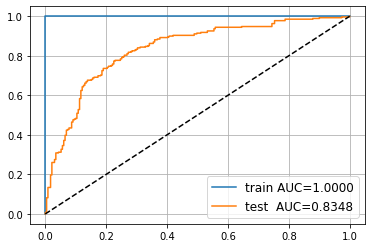

In [68]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [69]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
if torch.cuda.is_available():
    device = torch.device("cuda")  

from sklearn.metrics import accuracy_score

In [70]:
from utils import plot_train_process

In [95]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(5707, 200))
model.add_module('a1', nn.ReLU())
model.add_module('l2', nn.Linear(200, 2))
model = model.to(device)

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [123]:
# loss_function = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss().to(device)

In [124]:
opt = torch.optim.AdamW(model.parameters(), lr=3e-3)

In [125]:
X_train_bow_torch = torch.from_numpy(X_train_bow).to(device)
y_train_torch = torch.from_numpy(y_train).to(device)

X_test_bow_torch = torch.from_numpy(X_test_bow).to(device)
y_test_torch = torch.from_numpy(y_test).to(device)

Let's test that everything is fine

In [126]:
# example loss
loss = loss_func(model(X_train_bow_torch[:3]), y_train_torch[:3])
lr_scheduler = ReduceLROnPlateau(opt, patience=5)

In [127]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [128]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    loss_func,
    n_iterations=500,
    batch_size=25,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))
                
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_func(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()


        local_train_loss_history.append(loss.data.cpu().numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_func(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

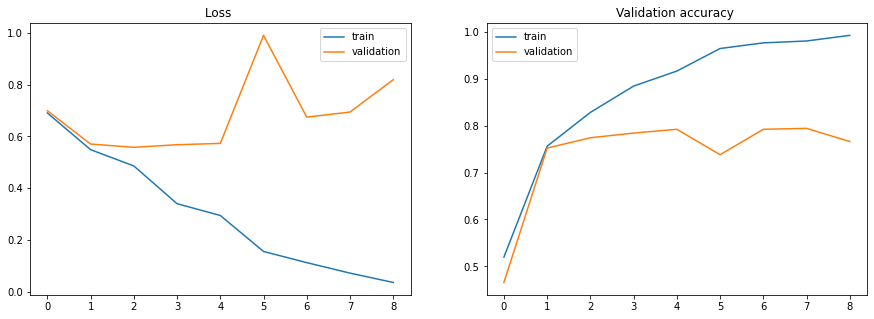

In [ ]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, loss_func)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve


def plot_roc_auc(X_train, X_test, y_train, y_test, model):
    for name, X, y, model in [
        ('train', X_train, y_train, model),
        ('test ', X_test, y_test, model)
    ]:
        proba = model(X).detach().cpu().numpy()[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()

plot_roc_auc(X_train_bow_torch, X_test_bow_torch, y_train, y_test, model)

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [114]:
bow_vocabulary_dict = get_bow_vocabulary_dict(texts_train, 3000)

X_train_bow = texts_to_bow(texts_train, bow_vocabulary_dict)
X_test_bow = texts_to_bow(texts_test, bow_vocabulary_dict)

X_train_bow_torch = torch.from_numpy(X_train_bow).to(device)
y_train_torch = torch.from_numpy(y_train).to(device)

X_test_bow_torch = torch.from_numpy(X_test_bow).to(device)
y_test_torch = torch.from_numpy(y_test).to(device)

model = nn.Sequential()
model.add_module('l1', nn.Linear(5707, 200))
model.add_module('a1', nn.ReLU())
model.add_module('l2', nn.Linear(200, 2))
model = model.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-3)
loss_func = nn.CrossEntropyLoss().to(device)
loss = loss_func(model(X_train_bow_torch[:3]), y_train_torch[:3])
lr_scheduler = ReduceLROnPlateau(opt, patience=5)

train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, loss_func)

RuntimeError: mat1 dim 1 must match mat2 dim 0

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [ ]:
# Your beautiful code here

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [ ]:
### YOUR CODE HERE

In [ ]:
X_train_tfidf_torch = ### YOUR CODE HERE
X_test_tfidf_torch = ### YOUR CODE HERE

y_train_torch = ### YOUR CODE HERE
y_test_torch = ### YOUR CODE HERE

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [ ]:
# Your beautiful code here

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

_Your beautiful thoughts here_

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [ ]:
# Your beautiful code here